In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
# load the split datasets from the files

X_train = np.load("/content/drive/MyDrive/Feature_extraction_wav2vec/data_split/train_features.npy")
y_train = np.load("/content/drive/MyDrive/Feature_extraction_wav2vec/data_split/train_labels.npy")
X_val = np.load("/content/drive/MyDrive/Feature_extraction_wav2vec/data_split/val_features.npy")
y_val = np.load("/content/drive/MyDrive/Feature_extraction_wav2vec/data_split/val_labels.npy")
X_test = np.load("/content/drive/MyDrive/Feature_extraction_wav2vec/data_split/test_features.npy")
y_test = np.load("/content/drive/MyDrive/Feature_extraction_wav2vec/data_split/test_labels.npy")

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_train.shape)
print(y_val.shape)


(9350, 149, 768)
(9350,)
(9350, 149, 768)
(2338,)


In [ ]:
input_shape = X_train.shape[1:]  # Remove the indexing for shape
input_shape

(149, 768)

In [ ]:
from keras.layers.serialization import activation
import keras as keras
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, SpatialDropout1D,Dropout
early_stop = EarlyStopping(monitor='val_loss', patience=6)
input_shape = (X_train.shape[1], X_train.shape[2],1)

model = keras.Sequential()
# conv layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.TimeDistributed(keras.layers.Flatten(input_shape=(9, 3, 32))))

# GRU block 1, 2, output
model.add(keras.layers.GRU(32, return_sequences=True, name='gru1'))
model.add(keras.layers.GRU(32, return_sequences=False, name='gru2'))
model.add(keras.layers.Dropout(0.3))

#output layer
model.add(keras.layers.Dense(6, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=40, callbacks=[early_stop])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 147, 766, 32)      320       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 383, 32)      0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 74, 383, 32)      128       
 hNormalization)                                                 
                                                                 
 time_distributed_4 (TimeDis  (None, 74, 12256)        0         
 tributed)                                                       
                                                                 
 gru1 (GRU)                  (None, 74, 32)            1179840   
                                                      

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=40, callbacks=[early_stop])

Epoch 1/40
293/293 [==============================] - 189s 630ms/step - loss: 1.7327 - accuracy: 0.2771 - val_loss: 1.7754 - val_accuracy: 0.2340
Epoch 2/40
293/293 [==============================] - 181s 617ms/step - loss: 1.5960 - accuracy: 0.3571 - val_loss: 1.5563 - val_accuracy: 0.3914
Epoch 3/40
293/293 [==============================] - 187s 637ms/step - loss: 1.5264 - accuracy: 0.3972 - val_loss: 1.5062 - val_accuracy: 0.4115
Epoch 4/40
293/293 [==============================] - 205s 701ms/step - loss: 1.4854 - accuracy: 0.4270 - val_loss: 1.4785 - val_accuracy: 0.4264
Epoch 5/40
293/293 [==============================] - 190s 649ms/step - loss: 1.4412 - accuracy: 0.4401 - val_loss: 1.4665 - val_accuracy: 0.4226
Epoch 6/40
293/293 [==============================] - 191s 654ms/step - loss: 1.4000 - accuracy: 0.4643 - val_loss: 1.4473 - val_accuracy: 0.4333
Epoch 7/40
293/293 [==============================] - 190s 649ms/step - loss: 1.3639 - accuracy: 0.4818 - val_loss: 1.4273 -

In [ ]:
from keras.models import load_model
model.save("/content/drive/MyDrive/CNN_GRU/model2/modelCNNGRU.h5")

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

92/92 - 14s - loss: 1.4660 - accuracy: 0.4389 - 14s/epoch - 147ms/step

Test accuracy: 0.4389325976371765


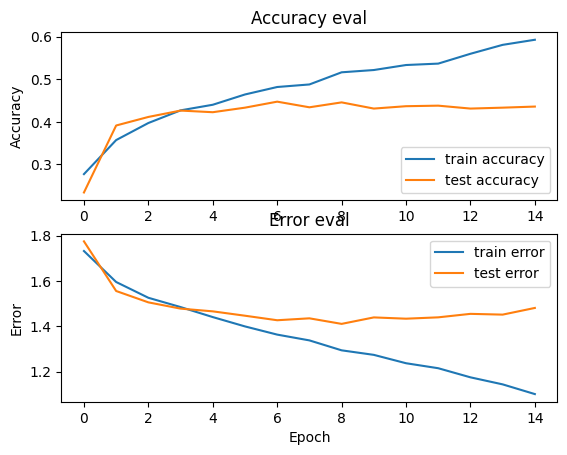

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2)

# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error sublpot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

plt.show()


In [ ]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))